# Continuous transformation of Boolean Regulatory Networks using SQUAD

This notebook exemplifies the implementation of the SQUAD methodology to transform a specific cartoon Boolean Regulatory Network (BRN) example to a continuous model formalism. For a more formally discussion of Regulatory Network models, see Mendez *et al*, 2017. The Regulatory Network RN is first modeled as a dynamical discrete system and the simulation of a trajectory is implemented using the R package BoolNet. In the next section, we define the same cartoon example RN model, but in this case a trajectory is simulated using SQUAD in the form of a continuous system.


## 1. Definition of the RN model using a discrete BRN formalism

In the following figure the topology of the example cartoon RN is shown. 

<img src="images/dinamica_minired.jpg">

Addionally to the network topology, to properly define a dynamic Boolean Network is also necessary to know regulatorydependencies of the nodes. Regulatory interactions or dependencies can be formalized in BRN models by using logic propositions. Logic rules can be seen as a description of the combinations of values of the regulators for which a node takes a "ON" value. For example, in the RN shown above the node B  is "ON"  at time $t+1$ iff A is "ON" and C is "ON" at time $t$.   Formally, $B_{t+1} = A_{t} \land \lnot B_{t}$.  Where the symbols $\land$, $\lor$, and $\lnot$ represent the logic operators AND, OR, and NOT,respectively. In the same manner the nodes regulatory dependencies can be defined, as follows: 

$A_{t+1} = A_{t}$ 

$B_{t+1} = A_{t} \land \lnot B_{t}$

$C_{t+1} = \lnot C_{t} \land \lnot B_{t}$

Note that these model logic updating rules are defined in the CartoonNetwork.R in BoolNet format. 

## 2. Simulation of BRN model 

To carry out the simulations we will use the  BoolNet R package. The next code load the network defined in the CartoonNetwrok.R file, then performs the the simulation of a trajectory starting at the initial state $(A,B,C) = (0,1,1)$.

,1,2,3
A,0,0,0
B,1,0,0
C,1,0,1


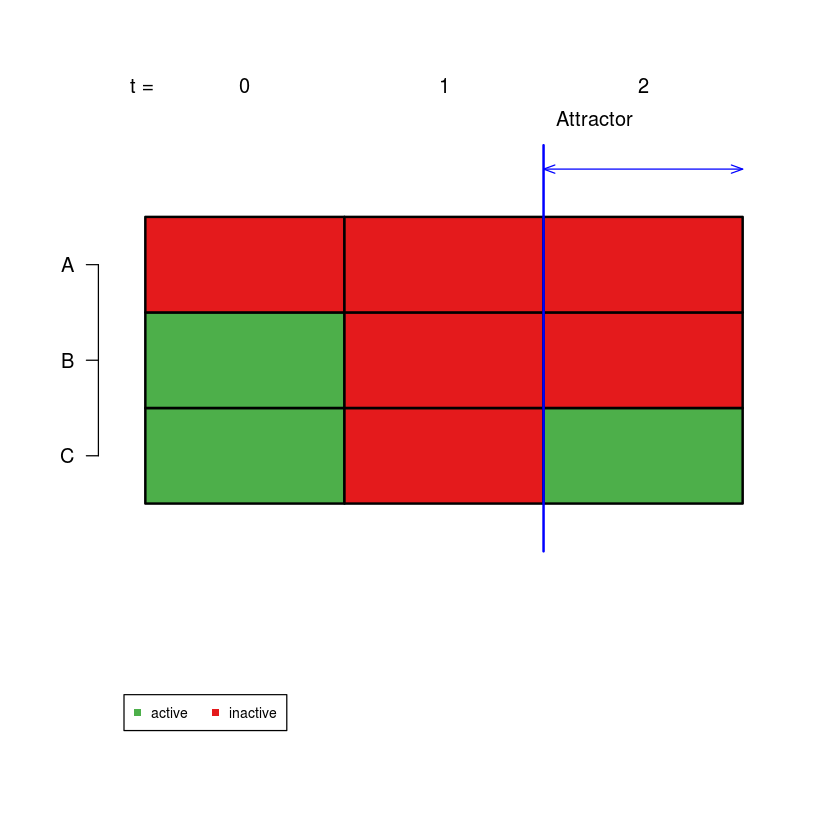

In [13]:
# loading dependencies
library(BoolNet)

# load the network
net<-loadNetwork("cartoonNetwork.R")

# define a initial state (A,B,C) = (0,1,1)
initialState<-generateState(net,specs=c("A"=0,"B"=1,"C"=1))

# simulate a discrete trajectory 
plotSequence(net,initialState)

The plot shows the evolution of the cartoon regulatory network model defined in **section 1**. Starting at the initial time $(0,1,1)$ the system changes until it converges to an steady state, that is, an state in which the system does not change anymore, in this case $(A,B,C) = (0,0,1)$. 

## 3. Continuous transformation of the BRN model using SQUAD

The transformation of the BRN defined in **section 1** a two step procedure is carried out. First the logic propositions are extrapolated to continuous functions. This is acomplished by the straightforward replacement of Boolean by continuous variables that takes all values in the interval $[0,1]$. Then, the logic operators $\land$, $\lor$, and $\lnot$ in the net rules propositions are replaced by the fuzzy logic operators *min*, *max* and $1 - x$, where $x$ is a continuous value of a regulator of the node. 
For example, in the BRN defined in **section 1** the net rules propositions are replaced by the following continuous functions.

$A_{t+1} = A_{t} $

$B_{t+1} = min(A_{t}, 1 - B_{t}) $

$C_{t+1} = min(1 - A_{t}, 1 - C_{t})$

Note that when the continuous variables takes Boolean values (0/1), the functions so defined take the same values of that logic propositions functions with which they were defined.

In the second step the SQUAD function is applied to the previuosly defined continuous functions. The SQUAD function is a standardized skeleton that allows to translate in a standardized manner the logic rules of RN into a Regulatory Network dynamical model by the use of the following equation:

$$ \frac{dx_k}{dt} = \frac{- e^{0.5h_k} + e^{-h_k(\omega_k - 0.5)}}{(1 - e^{0.5h_k})(1 + e^{-h_k(\omega_k-0.5)})} - {\gamma_k}x_k $$

The rate of change of each $x_k$ node is controlled by an activation and a decay term. This function defines a sigmoid curve where the parameter $h_k$ controls the stepness of the function. For high values of $h_k$ the function resembles a step function charachteristic of Boolean models. The logic rules summarizing the regulation of each node are included in the $\omega_k$ parameter, while the decay rate of the node is controlled by the $\gamma_k$ parameter.

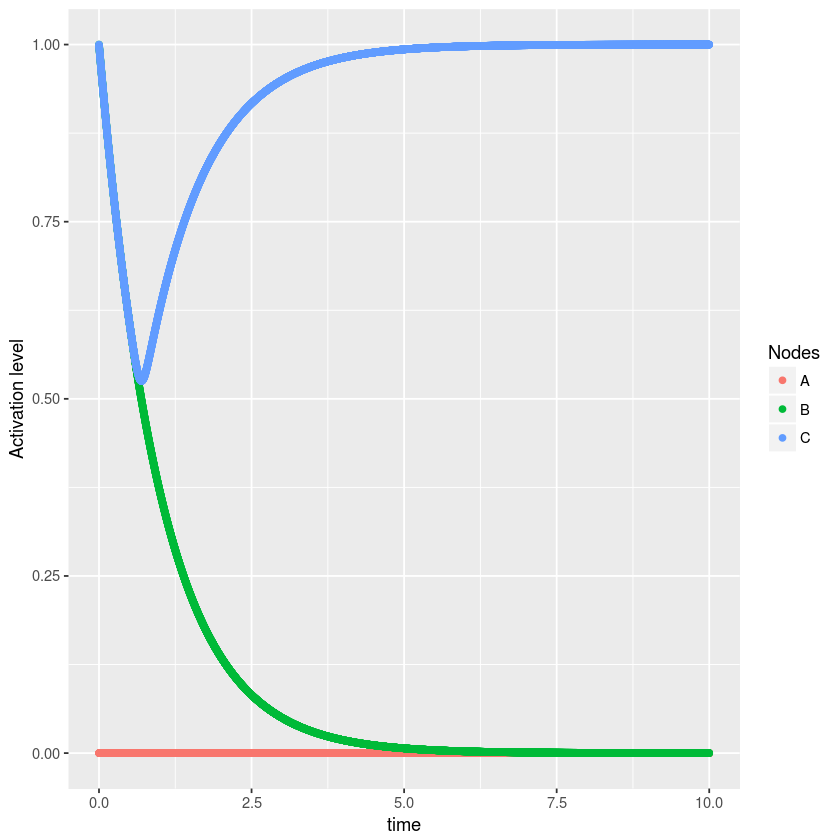

In [16]:
# loading dependencies
library(deSolve)
library(ggplot2)
library(reshape2)

# define network parameters
parameters <- c(h = 50,gamma = 1)

# define SQUAD generic function
SQUAD<-function(x,w,gamma,h){
  val<- ((-exp(0.5*h) + exp(-h*(w-0.5))) / ((1-exp(0.5*h)) * (1+exp(-h*(w-0.5))))) - (gamma*x)
  return(val)
}

# define ODE SQUAD system using deSolve R package
squadInteractions<-function(times,state,parameters) {
  with(as.list(c(state,parameters)),{
    w_A <- A
    w_B <- min(A,1-C)
    w_C <- 1 - max(A,B)
    dA <- SQUAD(A,w_A,gamma,h)
    dB <- SQUAD(B,w_B,gamma,h)
    dC <- SQUAD(C,w_C,gamma,h)
    return(list(c(dA,dB,dC)))
  })
}

# define interval for numeric integration
times<-seq(0,10,0.001)

# simulate the same trajectory but in a continuous manner
result<-ode(y=initialState,times=times,func=squadInteractions,parms = parameters,atol=10e-6, rtol=10e-6)
result.df<-result.df<-melt(as.data.frame(result), id.vars="time")
# plot the results
plot<-qplot(time, value, data=result.df, colour=variable)
plot<-plot+labs(colour="Nodes", y="Activation level")
plot


Note that as in the discrete system counterpart the system evolves until a steady stae $(A,B,C) = (0,0,1)$, in this case is analogous to the BRN model.